# Homework Assignment 2. Image Classification.

In this assignment, you need to train an image classifier. We will work with a dataset for classifying Telegram emojis. You can explore the images in the dataset yourself. It contains 100 classes, with about 100 images per class. The classes are numbered according to the emoji code they correspond to. You can download the dataset [here](https://disk.yandex.ru/d/elNF0DS94o2GVA).

Dataset structure: There are directories `train/` and `val/`, which contain training and validation data. Inside `train/` and `val/`, there are subdirectories corresponding to the image classes, and within them are the actual images.

**Assignment**. You need to complete two tasks:

1) Achieve an accuracy **on the validation set of at least 0.4**. In this task, **using pre-trained models and resizing images is prohibited**. (5 points)

2) Achieve an accuracy **on the validation set of at least 0.8**. In this task, resizing and using pre-trained models are allowed. (5 points)

Write a brief report on the experiments you conducted. What worked and what didn't? Why did you decide to do things this way and not another? Be sure to provide references to others' code if you use it. Also, cite articles, blog posts, Stack Overflow questions, YouTube videos from machine learning YouTubers, courses, tips from Uncle Vasya, and any other additional materials you use.

Your code must pass all the `assert` statements below.

**Using external data for training is strictly prohibited in both tasks. Training on the validation set is also prohibited.**

**Grading criteria**: The score is calculated using a simple formula: `min(10, 10 * Your accuracy / 0.4)` for the first task and `min(10, 10 * (Your accuracy - 0.4) / 0.4)` for the second. The score is rounded to tenths according to arithmetic rules.

**Tips and guidelines**:
- You will likely need to search a lot about classification and how to make it work. This is normal; everyone does it. But remember, you must be prepared to answer for copied code :)
- Use augmentations. For this, use the `torchvision.transforms` module or the [albumentations](https://github.com/albumentations-team/albumentations) library.
- You can train from scratch or fine-tune (depending on the task) models from `torchvision`.
- We recommend first writing a dataset class (or using the `ImageFolder` class) that returns images and their corresponding labels, and then writing training functions based on the templates below. However, we do not force you to do this. If it's inconvenient, you can write code in your preferred style. Keep in mind that excessive modifications to the templates below may lead to more questions about your code :)
- Validate. Track errors as early as possible to avoid wasting time.
- To debug code quickly, try training on a small subset of the dataset (e.g., 5–10 images just to ensure the code runs). Once you’ve debugged everything, move on to training on the full dataset.
- For each run, make exactly one change to the model/augmentations/optimizer to understand what affects the results and how.
- Fix the random seed.
- Start with simple models and gradually move to more complex ones. Training lightweight models saves a lot of time.
- Use a learning rate scheduler. Reduce it when the validation loss stops decreasing.
- We recommend using a GPU. If you don't have one, use Google Colab. If you find it inconvenient to use regularly, write and debug all the code locally on a CPU, then run the already-written notebook in Colab.

Good luck & have fun! :)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics

**✨ Attention ✨**

In this homework assignment, we recommend using the `pytorch_lightning` library. However, access to its [documentation](https://lightning.ai/docs/pytorch/stable/) is blocked from Russian territory. You can:

1. Access it using a VPN.

2. Build the documentation yourself. To do this, clone the [GitHub repository](https://github.com/Lightning-AI/lightning/tree/master), open a terminal (on Windows, use Git Bash) inside it, and run the commands:

```shell
git submodule update --init --recursive
make docs
```

After that, open the generated file `docs/build/html/index.html`. For the commands to work, you must have `pip` installed in your environment. Full instructions are available [here](https://github.com/Lightning-AI/lightning/tree/master/docs).

3. Search for `<error message> pytorch lightning` or `<how to do this> pytorch lightning` online. Stack Overflow is still accessible from Russian territory 😉

4. Not use `pytorch_lightning` and write the model training loop yourself. For example, similar to the `fit` function from [Seminar 4](https://github.com/hse-ds/iad-deep-learning/blob/master/2023/seminars/04.%20Optim%20%26%20Lightning/04_Optim%26Lightning_solution.ipynb).

In [ ]:
import wandb

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

# You may add any imports you need

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

## Task 0

What Will Help You Achieve 10 out of 10 (One Task — 5 Points)

1. Use all possible optimization methods and experiment with them.
2. Learning rate tuning. Example from the previous seminar on how to do it: [How to find lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)
  trainer.tune(module, train_dataloader, eval_dataloader)
  trainer.fit(module, train_dataloader, eval_dataloader)
```

3. Data augmentation. [Useful documentation](https://pytorch.org/vision/main/transforms.html) and also the [Albumentations library](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8).
4. Model architecture selection.
5. You can write your own model manually in the `YourNet` class, or import a non-pretrained network of a known architecture from the `torchvision.models` module. One way to do this:
   * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
   * Documentation on available models and how to use them: [Useful documentation](https://pytorch.org/vision/stable/models.html).
6. Properly normalize data during creation. Example [click here, but this is also a comprehensive guide from start to finish](https://www.pluralsight.com/guides/image-classification-with-pytorch).
7. Model Checkpointing. Save your progress (models) so that if something goes wrong, you can restart from that point or simply reproduce your model's results.
   * Example with wandb: [Saving best models to wandb](https://docs.wandb.ai/guides/integrations/lightning)
   * A simpler way: [Saving models in PyTorch documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Data Preparation

In [ ]:

# YOU CAN DEFINE AUGMENTATIONS HERE
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.247, 0.243, 0.261))  # Нормализация
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.247, 0.243, 0.261))
])

train_dataset = ImageFolder('/kaggle/input/dataset-hw2/dataset/train/train', transform=train_transform)
val_dataset = ImageFolder('/kaggle/input/dataset-hw2/dataset/val/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

batch_size = 32


train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
) # YOUR CODE HERE
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True) # YOUR CODE HERE

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


In [ ]:
train_dataset[1][0].shape

torch.Size([3, 128, 128])

### Let's take a look at the pictures.

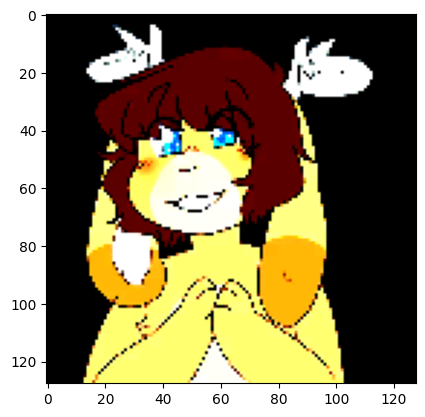

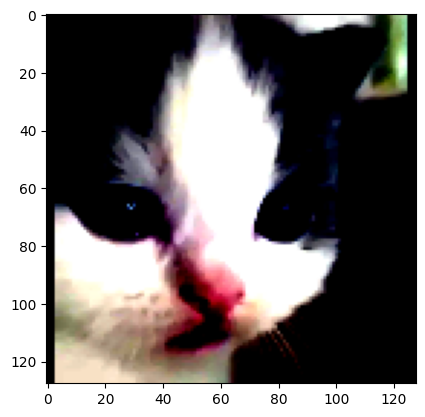

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break


## Task 1.

5 points  
Achieve a validation accuracy of at least 0.4. In this task, using pre-trained models and image resizing is prohibited.

To score (calculated below) 2.5/5 points (i.e., half the task), it's enough to follow a couple of simple practical rules:
1. Augmentation (without it, it will be very difficult)
2. Optimizers can (and should) be used together. However, when testing something, don't change multiple parameters at once—you'll lose the logic of the experiments.
3. Don't use fully connected models or the earliest convolutional ones; use more modern architectures (those covered in lectures).
4. Review the notebooks from past seminars and combine them into something general. The seminar notebooks are more than sufficient.

### Model (or just import a non-pretrained one)

In [ ]:
# different models for tests
from torchvision.models import mnasnet1_0
from torchvision.models import densenet121
from torchvision.models import efficientnet_b0
from torchvision.models import resnet34

In [ ]:
class ParamPamPamNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = densenet121(pretrained=False, num_classes=100)
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.predictions = torch.Tensor()
        pass

    def _forward(self, x):
        return self.model(x)
        pass

    def forward(self, images, target=None):
        output = self._forward(images)
        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.predictions = torch.cat((self.predictions, pred.cpu()), 0)
            self.acc = accuracy(self.predictions.long(), self.targets.long(), task="multiclass", num_classes=100)

        return loss
        pass

    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.predictions = torch.Tensor()
        return self.acc
        pass

### Train class lightning

In [ ]:
class ParamPamPamModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        res = self.model(x)
        return res

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        loss = self.model(images, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        loss = self.model(images, target)
        my_accuracy = accuracy(torch.argmax(self.model._forward(images), dim=-1).long(), target.long(), task="multiclass", num_classes=100)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", my_accuracy, prog_bar=True)


In [ ]:
seed_everything(123456)
wandb_logger = WandbLogger(project="hw2", log_model='all')
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ParamPamPamNet().to(device) # YOUR CODE HERE
module = ParamPamPamModule(model, learning_rate=0.0001) # YOUR CODE HERE


In [ ]:
seed_everything(123456)
trainer = pl.Trainer(accelerator="gpu", max_epochs=10, logger=wandb_logger)  # YOUR CODE HERE
trainer.fit(module, train_dataloader, val_dataloader)  # YOUR CODE HERE

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

### Validation of Task Results

In [ ]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    my_acc = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            loss = model(images, labels)
            acc_batch = model.get_accuracy(reset=True)
        my_acc += acc_batch
    my_acc = my_acc / len(test_dataloader)
    return my_acc

In [ ]:
seed_everything(123456)
model = model.to(device)


end_accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(5 * end_accuracy / 0.24, 0, 5):.2f} баллов")


  0%|          | 0/79 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

 99%|█████████▊| 78/79 [00:03<00:00, 28.26it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 79/79 [00:03<00:00, 24.15it/s]

Оценка за это задание составит 4.18 баллов


In [ ]:
end_accuracy

tensor(0.2006)

https://wandb.ai/evgen2004rus-hse-university/hw2?nw=nwuserevgen2004rus - Link to wandb with training results of different models

## Task 2

5 points  
Achieve a validation accuracy of at least 0.8. In this task, resizing images and using pre-trained models are allowed.

To score (calculated below) 2.5/5 points (i.e., half the task), it's enough to follow a couple of simple practical rules:
1. Augmentation (without it, it will be very difficult)
2. For optimizers, it's better to start with Adam with default parameters as a baseline.
3. Don't use fully connected models or the earliest convolutional ones; use more modern architectures (those covered in lectures or you can go further).
4. First, try checking the quality of the original model without fine-tuning, save it as a baseline. This will help you understand which layers need to be fine-tuned.
5. Review all notebooks from past seminars and combine them into something general. The seminar notebooks are more than sufficient.

### Model (or just import a non-pretrained one)

In [ ]:
from torchvision.models import resnet50

In [ ]:
class KwaKwa(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet50(weights='IMAGENET1K_V1')
        self.model.fc = nn.Linear(self.model.fc.in_features, 100)
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.predictions = torch.Tensor()
        pass

    def _forward(self, x):
        return self.model(x)
        # YOUR CODE HERE
        pass

    def forward(self, images, target=None):
        output = self._forward(images)
        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.predictions = torch.cat((self.predictions, pred.cpu()), 0)
            self.acc = accuracy(self.predictions.long(), self.targets.long(), task="multiclass", num_classes=100)

        return loss
        # YOUR CODE HERE
        pass

    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.predictions = torch.Tensor()
        return self.acc

### Train class lightning

In [ ]:
class KwaKwaModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        # YOUR CODE HERE
        self.model = model
        self.learning_rate = learning_rate
        pass

    def forward(self, x):
        res = self.model(x)
        return res
        # YOUR CODE HERE
        pass

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer
        # YOUR CODE HERE
        pass

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        loss = self.model(images, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

        # YOUR CODE HERE
        pass

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        loss = self.model(images, target)
        my_accuracy = accuracy(torch.argmax(self.model._forward(images), dim=-1).long(), target.long(), task="multiclass", num_classes=100)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", my_accuracy, prog_bar=True)
        # YOUR CODE HERE
        pass

In [ ]:
seed_everything(123456)
wandb_logger = WandbLogger(project="hw22222", log_model='all')
device = "cuda" if torch.cuda.is_available() else "cpu"

model = KwaKwa().to(device) # YOUR CODE HERE
module = KwaKwaModule(model, learning_rate=0.00001) # YOUR CODE HERE


In [ ]:
seed_everything(123456)
trainer = pl.Trainer(accelerator="gpu", max_epochs=10, logger=wandb_logger)  # YOUR CODE HERE
trainer.fit(module, train_dataloader, val_dataloader)  # YOUR CODE HERE

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

### Validation of Task Results

In [ ]:
seed_everything(123456)
model = model.to(device)

myacc = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(5 * myacc / 0.34, 0, 5):.2f} баллов")

100%|██████████| 79/79 [00:02<00:00, 26.93it/s]

Оценка за это задание составит 4.54 баллов


In [ ]:
myacc

tensor(0.3089)

# Experiment Report

Write the text here (or provide a link to wandb/any experiment tracker) for each task. It is not necessary to draw graphs directly here if you use ready-made trackers/monitoring tools for your models.

1. **Task 1** — [https://wandb.ai/evgen2004rus-hse-university/hw2?nw=nwuserevgen2004rus](https://wandb.ai/evgen2004rus-hse-university/hw2?nw=nwuserevgen2004rus)  
   I started by trying different ready-made models (without pre-training, of course) to see which one performed better. Once I found a suitable model, I experimented with adjusting the gradient descent step size, but the differences were either negligible or worse. I didn’t figure out how to save these models in wandb, so only scores are available there... Overall, all the models I tested were imported before the neural network class, where you can see which ones I tried.

2. **Task 2** — [https://wandb.ai/evgen2004rus-hse-university/hw22222](https://wandb.ai/evgen2004rus-hse-university/hw22222)  
   Here, I experimented with the learning rate (`lr`), but honestly, the results were quite messy. This is the extent of my capabilities here.